In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataclasses import dataclass
from torch.distributions.categorical import Categorical

import gymnasium as gym

C:\Users\yashr\miniconda3\envs\drlzh\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [3]:
@dataclass
class TrajectorySegment:
    states: torch.Tensor  # (M, N, S_dim) where N is the number of environments and M is the number of steps in one environment
    actions: torch.Tensor  # (M, N, A_dim)
    logprobs: torch.Tensor  # (M, N)
    values: torch.Tensor  # (M, N)
    rewards: torch.Tensor  # (M, N)
    dones: torch.Tensor  # (M, N)
    
    next_start_state: torch.Tensor  # (N, S_dim)

    def __len__(self):
        return self.states.shape[0]

In [4]:
@dataclass
class LearningBatch:
    states: torch.Tensor  # (B, S_dim)
    actions: torch.Tensor  # (B, A_dim)
    logprobs: torch.Tensor  # (B)
    advantages: torch.Tensor  # (B)
    returns: torch.Tensor  # (B)
    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, key):
        """Ability to slice a learning batch in mini-batches."""
        return LearningBatch(
            self.states[key],
            self.actions[key],
            self.logprobs[key],
            self.advantages[key],
            self.returns[key],
        )

In [5]:
class Batcher:
    def __init__(
        self,
        seg: TrajectorySegment,
        advantages: torch.Tensor,
        returns: torch.Tensor,
        n_mini_batches: int,
    ):
        self.batch_size = seg.states.shape[0] * seg.states.shape[1]  # rollout_len * num_bots
        self.mini_batch_size = int(self.batch_size // n_mini_batches)
        self.experiences = LearningBatch(
            *Batcher.flatten((seg.states, seg.actions, seg.logprobs, advantages, returns))
        )

    def shuffle(self):
        indices = np.arange(self.batch_size)
        np.random.shuffle(indices)
        return Batcher.MiniBatchIterator(self.experiences, indices, self.mini_batch_size)

    @staticmethod
    def flatten(t: tuple[torch.Tensor, ...]) -> tuple: 
        return tuple(x.flatten(0, 1) for x in t)

    class MiniBatchIterator:
        """Iterator for iterating over minibatches for training"""
        def __init__(self, experiences: LearningBatch, indices: list[int], mini_batch_size: int):
            self.experiences = experiences
            self.indices = indices # indices of the experiences in the Mini-batch
            self.mini_batch_size = mini_batch_size
            self.start = 0

        def __iter__(self):
            return self

        def __next__(self):
            if self.start >= len(self.experiences):
                raise StopIteration()
            start = self.start
            end = start + self.mini_batch_size
            inds = self.indices[start:end]
            self.start = end
            return self.experiences[inds]

In [6]:
class Agent(nn.Module):
    def __init__(self, state_size, action_size, lr=1e-3, hidden=128): 
        super().__init__()
    
        self.actor = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_size),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
        # We use the Adam optimizer in PPO
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    @torch.no_grad()
    def act(self, state: np.ndarray):
        """returns the action for collecting trajectory thus does not return the logprob"""
        state = torch.from_numpy(state).float().unsqueeze(0)
        logits = self.actor(state)
        dist = Categorical(logits=logits) # Categorical distribution for discrete action space
        action = dist.sample()
        return action.numpy()[0]
    
    def get_value(self, states):
        return self.critic(states)
    
    def get_action_dist(self, states): 
        logits = self.actor(states)
        return Categorical(logits=logits)
    
    def sample_action(self, states): # sampling action during training
        dist = self.get_action_dist(states)
        action = dist.sample()
        return action, dist.log_prob(action)
    
    def eval_action(self, states, actions):
        dist = self.get_action_dist(states)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        return logprobs, entropy
    
    def learn(
        self,
        batch: LearningBatch,
        entropy_coeff=0.01,
        vf_coeff=0.5,
        clip_coeff=0.1,
        max_grad_norm=0.5,
    ):
        newlogprobs, entropy = self.eval_action(batch.states, batch.actions)

        logratio = newlogprobs - batch.logprobs # log ratio of the newer and older policy
        ratio = logratio.exp()
        clipped_ratio = torch.clamp(ratio, 1 - clip_coeff, 1 + clip_coeff) # clipping so that there is not any abrupt changes in the policy 
        advantages = batch.advantages 
    
        L_entropy = entropy_coeff * entropy.mean() # encourages exploration by rewarding randomness.
        L_clipped = -torch.min(advantages * ratio, advantages * clipped_ratio).mean() # negative because we want to perform gradient ascent using gradient descent
        L_actor = L_clipped - L_entropy # same reason we are subrtracting L_entropy here
    
        newvalues = self.get_value(batch.states).view(-1) # calculates the critics predicted value for the batch of states
        L_critic = F.mse_loss(newvalues, batch.returns)
    
        L_ppo = L_actor + L_critic * vf_coeff
        self.optimizer.zero_grad()
        L_ppo.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), max_grad_norm) # Prevent large policy updates
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_grad_norm) # Prevent value-function overfitting & explosions
        self.optimizer.step()

In [7]:
@torch.no_grad()
def gae_advantages_and_returns(
    segment: TrajectorySegment, next_return: torch.Tensor, gamma=0.99, gae_lambda=0.95
):
    advantages = torch.zeros_like(segment.rewards)
    last_gae_lambda = 0
    for t in reversed(range(len(segment))): # because we recursively compute td_error and advantage
        next_non_terminal = 1.0 - segment.dones[t] # prevents propagation of advantage in bootstrapping across episodes 
        td_error = (
            segment.rewards[t] + (gamma * next_return * next_non_terminal) - segment.values[t]
        )
        advantages[t] = td_error + gamma * gae_lambda * next_non_terminal * last_gae_lambda # GAE calculation where we take the discounted advantage as bootstrapping
        next_return = segment.values[t] 
        last_gae_lambda = advantages[t] # stores advantage from the next step

    returns = advantages + segment.values # calculate the returns as advantage plus returns 
    return advantages, returns

In [8]:
class PPO:
    """PPO implementation."""

    def __init__(
        self,
        env: gym.vector.VectorEnv,
        agent: Agent,
        rollout_size=512,
        mini_batch_size=64,
        n_update_epochs=4,
        solved_score=8.0,
        max_episodes=15000
    ):
        self.env = env
        self.agent = agent
        self.num_bots = env.num_envs
        self.n_mini_batches = (rollout_size * self.num_bots) // mini_batch_size
        self.n_update_epochs = n_update_epochs
        self.action_size = env.single_action_space.n
        self.state_size = env.single_observation_space.n
        self.rollout_size = rollout_size
        self.solved_score = solved_score
        self.n_episode = 0
        self.episode_returns = np.zeros(self.num_bots)
        self.return_history = []
        self.max_episodes = max_episodes
        
    def train(self) -> list[float]:
        start_state, _ = self.env.reset()
        start_state = torch.tensor(self.one_hot(start_state), dtype=torch.float32) # we take the state as a one-hot encoded vector in Taxi-v3

        while True:
            segment = self.collect_trajectory_segment(start_state)

            next_return = self.agent.get_value(segment.next_start_state).flatten() # for calculating return and advantage
            advantages, returns = gae_advantages_and_returns(segment, next_return)
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8) # normalizing the advantages 


            batcher = Batcher(segment, advantages, returns, self.n_mini_batches)
            for _ in range(self.n_update_epochs):
                for mini_batch in batcher.shuffle():
                    self.agent.learn(mini_batch)

            start_state = segment.next_start_state
            if self.training_checkpoint(segment):
                break
                
        return self.return_history

    def collect_trajectory_segment(self, start_state):
        batch_dim = (self.rollout_size, self.num_bots)

        s_states = torch.zeros(batch_dim + (self.state_size,))
        s_actions = torch.zeros(batch_dim, dtype=torch.long)
        s_logprobs = torch.zeros(batch_dim)
        s_values = torch.zeros(batch_dim)
        s_rewards = torch.zeros(batch_dim)
        s_dones = torch.zeros(batch_dim)

        state = start_state
        for step in range(self.rollout_size):
            with torch.no_grad():
                action, logprob = self.agent.sample_action(state)
                value = self.agent.get_value(state)

            next_state, reward, term, trunc, _ = self.env.step(action.cpu().numpy())

            s_states[step] = state
            s_actions[step] = action
            s_logprobs[step] = logprob
            s_values[step] = value.flatten()
            s_rewards[step] = torch.Tensor(reward)
            s_dones[step] = torch.Tensor(np.logical_or(term, trunc))
            
            self.episode_returns += reward
            ended = np.logical_or(term, trunc)
            for i, done in enumerate(ended):
                if done:
                    self.return_history.append(self.episode_returns[i])
                    self.episode_returns[i] = 0
                    self.n_episode += 1 
    
            state = torch.tensor(self.one_hot(next_state), dtype=torch.float32)

        return TrajectorySegment(
            s_states, s_actions, s_logprobs, s_values, s_rewards, s_dones, next_start_state=state
        )

    @torch.no_grad()
    def training_checkpoint(self, segment):
        """ Print statistics and determines whether to terminate traininig"""
        if self.n_episode >= self.max_episodes:
            print(f"\nReached max episodes: {self.max_episodes}. Stopping training.")
            return True
        
        if len(self.return_history) < 100:
            return False

        avg_score = np.mean(self.return_history[-100:])
        print(f"Episode {self.n_episode}  Average Score: {avg_score:.2f}")

        if avg_score >= self.solved_score:
            print(f"\nSolved Taxi-v3! Average score: {avg_score:.2f}")
            return True

        return False

    def one_hot(self, state_array): # for encoding the state (in Taxi-v3 there are 500 possible states and the current state can be shown as a one-hot encoded vector)
        # input shape: (num_envs,)
        # output shape: (num_envs, 500)
        out = np.eye(self.state_size)[state_array]
        return out

In [11]:
# aggresive PPO Agent with high learning rate 
# It exhibits initial fast learning but the curve is high variance and exploration is chaotic
vector_env = gym.make_vec("Taxi-v3", num_envs=10)
vector_env = gym.wrappers.vector.RecordEpisodeStatistics(vector_env)
vector_env = init_random(vector_env)
agent = Agent(vector_env.single_observation_space.n, vector_env.single_action_space.n, lr=1e-2)
ppo_aggressive = PPO(vector_env, agent,solved_score=8.0)
ppo_aggressive.train()

Episode 103  Average Score: -688.89
Episode 128  Average Score: -635.07
Episode 153  Average Score: -609.84
Episode 181  Average Score: -578.14
Episode 210  Average Score: -532.25
Episode 240  Average Score: -491.99
Episode 271  Average Score: -452.87
Episode 305  Average Score: -395.69
Episode 350  Average Score: -302.73
Episode 388  Average Score: -265.95
Episode 430  Average Score: -242.14
Episode 476  Average Score: -208.80
Episode 536  Average Score: -163.08
Episode 593  Average Score: -135.77
Episode 663  Average Score: -106.28
Episode 755  Average Score: -63.91
Episode 846  Average Score: -67.98
Episode 959  Average Score: -41.97
Episode 1078  Average Score: -36.90
Episode 1211  Average Score: -29.63
Episode 1353  Average Score: -25.65
Episode 1497  Average Score: -20.85
Episode 1668  Average Score: -13.91
Episode 1872  Average Score: -6.36
Episode 2070  Average Score: -7.07
Episode 2291  Average Score: -2.70
Episode 2529  Average Score: -0.22
Episode 2784  Average Score: 1.46
E

[np.float64(-884.0),
 np.float64(-884.0),
 np.float64(-740.0),
 np.float64(-965.0),
 np.float64(-758.0),
 np.float64(-731.0),
 np.float64(-839.0),
 np.float64(-776.0),
 np.float64(-758.0),
 np.float64(-839.0),
 np.float64(-803.0),
 np.float64(-848.0),
 np.float64(-821.0),
 np.float64(-713.0),
 np.float64(-668.0),
 np.float64(-866.0),
 np.float64(-821.0),
 np.float64(-866.0),
 np.float64(-830.0),
 np.float64(-776.0),
 np.float64(-740.0),
 np.float64(-920.0),
 np.float64(-749.0),
 np.float64(-695.0),
 np.float64(-794.0),
 np.float64(-758.0),
 np.float64(-758.0),
 np.float64(-677.0),
 np.float64(-839.0),
 np.float64(-902.0),
 np.float64(-373.0),
 np.float64(-474.0),
 np.float64(-758.0),
 np.float64(-803.0),
 np.float64(-821.0),
 np.float64(-758.0),
 np.float64(-659.0),
 np.float64(-731.0),
 np.float64(-623.0),
 np.float64(-686.0),
 np.float64(-359.0),
 np.float64(-659.0),
 np.float64(-668.0),
 np.float64(-749.0),
 np.float64(-731.0),
 np.float64(-767.0),
 np.float64(-578.0),
 np.float64(-

In [12]:
# PPO Agent with standard learning rate 
# it exhibits stable learning with steady updates and the only one to reach the solved score
vector_env = gym.make_vec("Taxi-v3", num_envs=10)
vector_env = gym.wrappers.vector.RecordEpisodeStatistics(vector_env)
vector_env = init_random(vector_env)
agent = Agent(vector_env.single_observation_space.n, vector_env.single_action_space.n, lr=1e-3)
ppo = PPO(vector_env, agent,solved_score=8.0)
ppo.train()

Episode 102  Average Score: -689.63
Episode 127  Average Score: -638.84
Episode 153  Average Score: -604.20
Episode 182  Average Score: -561.04
Episode 207  Average Score: -528.44
Episode 239  Average Score: -470.59
Episode 269  Average Score: -420.32
Episode 306  Average Score: -379.99
Episode 334  Average Score: -369.88
Episode 370  Average Score: -347.33
Episode 405  Average Score: -313.44
Episode 437  Average Score: -291.63
Episode 479  Average Score: -263.05
Episode 521  Average Score: -237.35
Episode 580  Average Score: -169.79
Episode 631  Average Score: -139.47
Episode 701  Average Score: -118.13
Episode 771  Average Score: -99.13
Episode 851  Average Score: -87.61
Episode 930  Average Score: -80.78
Episode 1030  Average Score: -54.41
Episode 1141  Average Score: -42.91
Episode 1270  Average Score: -32.94
Episode 1421  Average Score: -21.86
Episode 1602  Average Score: -12.66
Episode 1787  Average Score: -14.15
Episode 1991  Average Score: -6.76
Episode 2200  Average Score: -6.

[np.float64(-884.0),
 np.float64(-884.0),
 np.float64(-740.0),
 np.float64(-965.0),
 np.float64(-758.0),
 np.float64(-731.0),
 np.float64(-839.0),
 np.float64(-776.0),
 np.float64(-758.0),
 np.float64(-839.0),
 np.float64(-803.0),
 np.float64(-848.0),
 np.float64(-821.0),
 np.float64(-713.0),
 np.float64(-668.0),
 np.float64(-866.0),
 np.float64(-821.0),
 np.float64(-866.0),
 np.float64(-830.0),
 np.float64(-776.0),
 np.float64(-758.0),
 np.float64(-929.0),
 np.float64(-767.0),
 np.float64(-731.0),
 np.float64(-794.0),
 np.float64(-758.0),
 np.float64(-785.0),
 np.float64(-686.0),
 np.float64(-839.0),
 np.float64(-893.0),
 np.float64(-375.0),
 np.float64(-758.0),
 np.float64(-686.0),
 np.float64(-785.0),
 np.float64(-776.0),
 np.float64(-767.0),
 np.float64(-695.0),
 np.float64(-704.0),
 np.float64(-632.0),
 np.float64(-704.0),
 np.float64(-359.0),
 np.float64(-668.0),
 np.float64(-731.0),
 np.float64(-749.0),
 np.float64(-731.0),
 np.float64(-749.0),
 np.float64(-587.0),
 np.float64(-

In [13]:
# Conservative PPO Agent with low learning rate 
# It exhibits a very smooth curve but underfits the environment as it is stuck on -200 reward
vector_env = gym.make_vec("Taxi-v3", num_envs=10)
vector_env = gym.wrappers.vector.RecordEpisodeStatistics(vector_env)
vector_env = init_random(vector_env)
agent = Agent(vector_env.single_observation_space.n, vector_env.single_action_space.n, lr=1e-4)
ppo_conservative = PPO(vector_env, agent,solved_score=8.0)
ppo_conservative.train()

Episode 101  Average Score: -689.76
Episode 124  Average Score: -643.14
Episode 152  Average Score: -593.09
Episode 175  Average Score: -563.76
Episode 204  Average Score: -517.43
Episode 226  Average Score: -485.93
Episode 254  Average Score: -450.85
Episode 282  Average Score: -422.83
Episode 304  Average Score: -405.46
Episode 332  Average Score: -379.18
Episode 354  Average Score: -362.28
Episode 382  Average Score: -339.50
Episode 405  Average Score: -325.91
Episode 432  Average Score: -313.49
Episode 456  Average Score: -304.72
Episode 484  Average Score: -294.24
Episode 507  Average Score: -285.24
Episode 534  Average Score: -271.65
Episode 562  Average Score: -261.12
Episode 585  Average Score: -254.90
Episode 613  Average Score: -249.86
Episode 635  Average Score: -249.50
Episode 663  Average Score: -249.41
Episode 687  Average Score: -247.70
Episode 714  Average Score: -244.73
Episode 737  Average Score: -239.06
Episode 764  Average Score: -233.54
Episode 788  Average Score: 

[np.float64(-884.0),
 np.float64(-884.0),
 np.float64(-740.0),
 np.float64(-965.0),
 np.float64(-758.0),
 np.float64(-731.0),
 np.float64(-839.0),
 np.float64(-776.0),
 np.float64(-758.0),
 np.float64(-839.0),
 np.float64(-803.0),
 np.float64(-848.0),
 np.float64(-821.0),
 np.float64(-713.0),
 np.float64(-668.0),
 np.float64(-866.0),
 np.float64(-821.0),
 np.float64(-866.0),
 np.float64(-830.0),
 np.float64(-776.0),
 np.float64(-758.0),
 np.float64(-929.0),
 np.float64(-767.0),
 np.float64(-740.0),
 np.float64(-794.0),
 np.float64(-758.0),
 np.float64(-794.0),
 np.float64(-686.0),
 np.float64(-848.0),
 np.float64(-884.0),
 np.float64(-375.0),
 np.float64(-758.0),
 np.float64(-695.0),
 np.float64(-794.0),
 np.float64(-731.0),
 np.float64(-803.0),
 np.float64(-677.0),
 np.float64(-695.0),
 np.float64(-650.0),
 np.float64(-713.0),
 np.float64(-377.0),
 np.float64(-641.0),
 np.float64(-749.0),
 np.float64(-749.0),
 np.float64(-713.0),
 np.float64(-767.0),
 np.float64(-578.0),
 np.float64(-

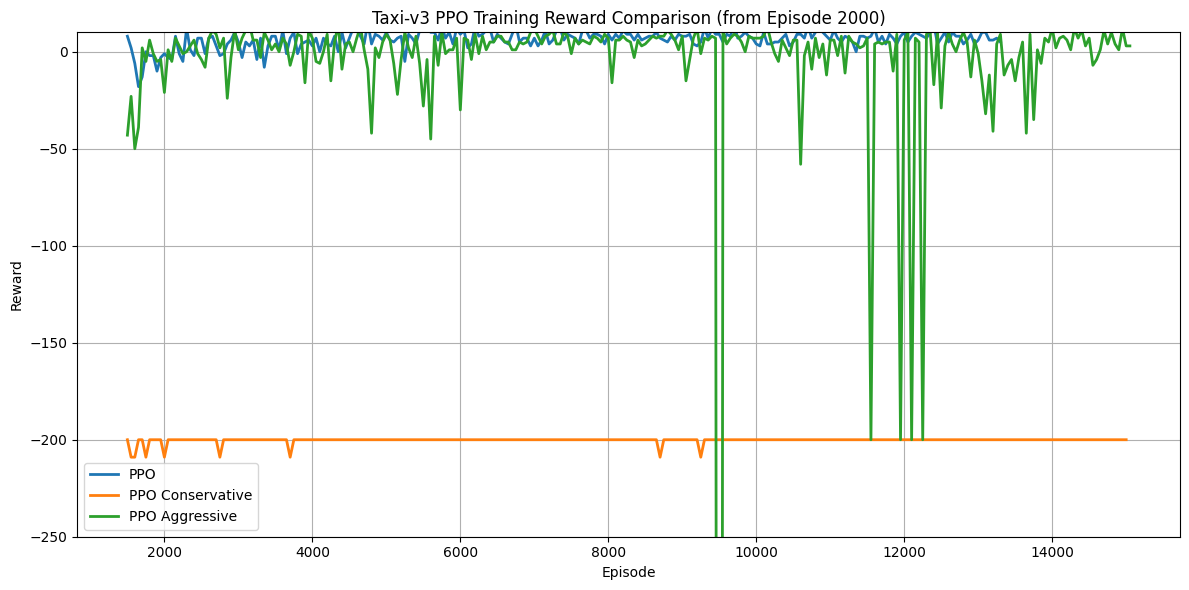

In [21]:
import matplotlib.pyplot as plt

step = 50
start_ep = 1500  # start plotting from episode 1500

def downsample(arr, step):
    return arr[::step]

# downsampling the episode histories to make the graph clearer
ppo_downsampled = downsample(ppo.return_history, step)
ppo_cons_downsampled = downsample(ppo_conservative.return_history, step)
ppo_aggr_downsampled = downsample(ppo_aggressive.return_history, step)

# Build x-axes
ppo_x_full = list(range(0, len(ppo_downsampled) * step, step))
ppo_cons_x_full = list(range(0, len(ppo_cons_downsampled) * step, step))
ppo_aggr_x_full = list(range(0, len(ppo_aggr_downsampled) * step, step))

# Slice everything from 1500 onward
def slice_from_episode(x, y, start):
    return [xi for xi, yi in zip(x, y) if xi >= start], [yi for xi, yi in zip(x, y) if xi >= start]

ppo_x, ppo_hist = slice_from_episode(ppo_x_full, ppo_hist_full, start_ep)
ppo_cons_x, ppo_cons_hist = slice_from_episode(ppo_cons_x_full, ppo_cons_hist_full, start_ep)
ppo_aggr_x, ppo_aggr_hist = slice_from_episode(ppo_aggr_x_full, ppo_aggr_hist_full, start_ep)


plt.figure(figsize=(12, 6))

plt.plot(ppo_x, ppo_hist, label="PPO", linewidth=2)
plt.plot(ppo_cons_x, ppo_cons_hist, label="PPO Conservative", linewidth=2)
plt.plot(ppo_aggr_x, ppo_aggr_hist, label="PPO Aggressive", linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(-250, 10)  # y-axis range
plt.title("Taxi-v3 PPO Training Reward Comparison (from Episode 1500)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
